In [1]:
import sys
import subprocess
libraries = {'tensorflow'}
if 'tensorflow' not in sys.modules:
    subprocess.check_call([sys.executable, "-m", "pip", "install", 'tensorflow'], stdout = subprocess.DEVNULL)
else:
    print(f"tensorflow already in sys.modules")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
from statsmodels.nonparametric.kde import KDEUnivariate
import logging
from itertools import product
import time
from scipy.stats import wasserstein_distance
import os
from decimal import Decimal, ROUND_HALF_UP
import seaborn as sns

In [3]:
# Load iris dataset
data = pd.read_csv('../bodyPerformance.csv')
rounds = [0,1,1,1,0,0,1,1,0,0]

In [4]:
if False:
    nuoret = pd.DataFrame.copy(data, deep = True)
    nuoret['age'] = nuoret['age'] * 0.9
    nuoret = nuoret[nuoret['age'] < data['age'].min()].reset_index(drop = True)
    
    vanhat = pd.DataFrame.copy(data, deep = True)
    vanhat['age'] = vanhat['age'] * 1.1
    vanhat = vanhat[vanhat['age'] > data['age'].max()].reset_index(drop = True)
    
    nuoret['age_group'] = 1
    data['age_group'] = 2
    vanhat['age_group'] = 3
    data = pd.concat([data, nuoret, vanhat], ignore_index = True)

In [5]:
#X = data.drop(['gender', 'class'], axis = 1)
X = data.drop(['gender', 'class'], axis = 1)
y = data['gender']
columns = X.columns

In [6]:
data = data.drop(['class', 'gender'], axis = 1)
for column, x in zip(data.columns, rounds):
    deci = '0.1' if x else '0'
    data[column] = data[column].apply(lambda x: Decimal(str(x)).quantize(Decimal(deci), rounding=ROUND_HALF_UP)).astype(float)

In [7]:
#scaler = MinMaxScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

In [8]:
real_data = pd.DataFrame(X, columns=columns)
real_labels = y
data['gender'] = y

In [9]:
scaler = MinMaxScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data.drop(['gender'], axis = 1))
scaler.transform(data.drop(['gender'], axis = 1))

array([[-0.72093023,  0.375     , -0.12522361, ..., -0.63529412,
         0.5       ,  0.43234323],
       [-0.81395349,  0.1627907 , -0.47227191, ..., -0.65294118,
         0.325     ,  0.51155116],
       [-0.53488372,  0.5872093 , -0.07513417, ..., -0.68907563,
         0.225     ,  0.19471947],
       ...,
       [-0.1627907 ,  0.51744186, -0.03041145, ..., -0.65210084,
         0.125     ,  0.51155116],
       [ 1.        , -0.38662791, -0.43828265, ..., -0.71260504,
        -1.        , -0.5049505 ],
       [-0.39534884,  0.13372093, -0.28801431, ..., -0.7302521 ,
         0.275     ,  0.18811881]])

In [10]:
data

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender
0,27.0,172.3,75.2,21.3,80.0,130.0,54.9,18.4,60.0,217.0,M
1,25.0,165.0,55.8,15.7,77.0,126.0,36.4,16.3,53.0,229.0,M
2,31.0,179.6,78.0,20.1,92.0,152.0,44.8,12.0,49.0,181.0,M
3,32.0,174.5,71.1,18.4,76.0,147.0,41.4,15.2,53.0,219.0,M
4,28.0,173.8,67.7,17.1,70.0,127.0,43.5,27.1,45.0,217.0,M
...,...,...,...,...,...,...,...,...,...,...,...
13388,25.0,172.1,71.8,16.2,74.0,141.0,35.8,17.4,47.0,198.0,M
13389,21.0,179.7,63.9,12.1,74.0,128.0,33.0,1.1,48.0,167.0,M
13390,39.0,177.2,80.5,20.1,78.0,132.0,63.5,16.4,45.0,229.0,M
13391,64.0,146.1,57.7,40.4,68.0,121.0,19.3,9.2,0.0,75.0,F


In [11]:
X.shape

(13393, 10)

In [12]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_labels = one_hot_encoder.fit_transform(np.array(real_labels).reshape(-1, 1))

In [13]:
BATCH_SIZE_ARR = [32]
NOISE_DIM_ARR = [75]
TRAINING_STEPS_ARR = [10000]
LEARNING_RATES_GAN = [0.001]
LEARNING_RATES_DISCRIMINATOR = [0.001]

In [14]:
# Constants
#NOISE_DIM = 25
MALE_COUNT = sum(real_labels == 'M')
FEMALE_COUNT = sum(real_labels == 'F')
NUM_CLASSES = len(set(y))
NUM_FEATURES = X.shape[1]
#BATCH_SIZE = 128
#TRAINING_STEPS = 10000
POOR_TRAINING_STEPS = 1000
PATIENCE = 20
NO_IMPROVEMENT_COUNT = 0
BEST_VALIDATION_METRIC = 1e10

In [15]:
# Parameters for discriminator and generator models
parameters = {
    'Discriminator': {
        'input_dim': NUM_FEATURES,
        'hidden_layers': 2,
        'starting_neurons': 32,
        'first_output': NUM_FEATURES + NUM_CLASSES,
        'method': np.multiply,
        'adjustment': 0.5,
        'activation': 'leaky_relu',
        'output_neuron': 1,
        'output_activation': 'sigmoid',
        'learning_rate': None # Will be updated later
    },
    'Generator': {
        'input_dim': None, # Will be updated later
        'hidden_layers': 2,
        'starting_neurons': 16,
        'first_output': None, # Will be updated later
        'method': np.multiply,
        'adjustment': 2,
        'activation': 'leaky_relu',
        'output_neuron': NUM_FEATURES,
        'output_activation': 'tanh' # linear jatkuvaan dataan. tanh kun data on rajoitettu tiettyihin arvoihin.
    },
    'learning_rate': None # Will be updated later
}

In [16]:
# Generator
def create_generator_OLD(noise_dim):
    noise_input = Input(shape=(noise_dim,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([noise_input, class_input])
    hidden1 = Dense(16, activation='relu')(merged_input)
    hidden2 = Dense(32, activation='relu')(hidden1)
    #hidden3 = Dense(64, activation='relu')(hidden2)
    #hidden4 = Dense(128, activation='relu')(hidden3)
    output = Dense(NUM_FEATURES, activation='linear')(hidden2)
    model = Model(inputs=[noise_input, class_input], outputs=output)
    return model

In [17]:
# Discriminator
def create_discriminator_OLD():
    data_input = Input(shape=(NUM_FEATURES,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([data_input, class_input])
    #hidden1 = Dense(128, activation='relu')(merged_input)
    hidden1 = Dense(32, activation='relu')(merged_input)
    hidden2 = Dense(16, activation='relu')(hidden1)
    output = Dense(1, activation='sigmoid')(hidden2)
    model = Model(inputs=[data_input, class_input], outputs=output)
    return model

In [18]:
# cGAN
def create_cgan_OLD(generator, discriminator, noise_dim):
    noise_input = Input(shape=(noise_dim,))
    class_input = Input(shape=(NUM_CLASSES,))
    generated_data = generator([noise_input, class_input])
    validity = discriminator([generated_data, class_input])
    model = Model(inputs=[noise_input, class_input], outputs=validity)
    return model

In [19]:
def buildModels_OLD(noise_dim):
    # Create and compile the Discriminator
    discriminator = create_discriminator()
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

    # Create the Generator
    generator = create_generator(noise_dim)

    # Create the GAN
    gan = create_cgan(generator, discriminator, noise_dim)

    # Ensure that only the generator is trained
    discriminator.trainable = False

    gan.compile(loss='binary_crossentropy', optimizer=Adam())

    return generator, discriminator, gan

In [20]:
# Add layers to the model using the add method
def addLayers(model, hidden_layers, starting_neurons, first_output, method, adjustment, activation, output_neuron, output_activation):
    model.add(Dense(units = starting_neurons, activation = activation, input_dim = first_output))
    prev =  method(starting_neurons, adjustment)
    for x in range(1, hidden_layers):
        model.add(Dense(units = prev, activation = activation, input_dim = method(prev, adjustment)))
        prev = method(prev, adjustment)
    model.add(Dense(units = output_neuron, activation = output_activation))

def getActivationFunction(model):
    for l in model.layers:
      try:
        if type(l) == Sequential:
            for i in l.layers:
                print(i.activation)
        print(l.activation)
      except: # some layers don't have any activation
        pass

# Define the input shapes
def createModel(input_dim, hidden_layers, starting_neurons, first_output, method, adjustment, activation, output_neuron, output_activation, **kw):
    data_input = Input(shape=(input_dim,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([data_input, class_input]),
    # Create a Sequential model
    model = tf.keras.Sequential()
    addLayers(model, hidden_layers, starting_neurons, first_output, method, adjustment, activation, output_neuron, output_activation)
    full_model = Model(inputs=[data_input, class_input], outputs=model(merged_input))
    return full_model

def createCGAN(generator, discriminator, noise_dim):
    noise_input = Input(shape=(noise_dim,))
    class_input = Input(shape=(NUM_CLASSES,))
    generated_data = generator([noise_input, class_input])
    validity = discriminator([generated_data, class_input])
    model = Model(inputs=[noise_input, class_input], outputs=validity)
    return model

def buildModels(parameters, noise_dim):
    # Create and compile the Discriminator
    #discriminator = createModel(input_dim = NUM_FEATURES, hidden_layers = 2, starting_neurons = 32, first_output = NUM_FEATURES + NUM_CLASSES, method = np.multiply, adjustment = 0.5, activation = 'relu', output_neuron = 1, output_activation = 'sigmoid')
    discriminator_params = parameters['Discriminator']
    generator_params = parameters['Generator']
    discriminator =  createModel(**discriminator_params)
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = discriminator_params['learning_rate']))

    # Create the Generator
    #generator = createModel(input_dim = noise_dim, hidden_layers = 2, starting_neurons = 16, first_output = noise_dim + NUM_CLASSES, method = np.multiply, adjustment = 2, activation = 'relu', output_neuron = NUM_FEATURES, output_activation = 'linear')
    generator = createModel(**generator_params)
    
    # Create the GAN
    gan = createCGAN(generator, discriminator, noise_dim)

    # Ensure that only the generator is trained
    discriminator.trainable = False

    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = parameters['learning_rate']))

    return generator, discriminator, gan

In [21]:
# Generate instances for a given class
def generate_data(generator, data_class, num_instances, noise_dim, X):
    one_hot_class = one_hot_encoder.transform(np.array([[data_class]]))
    noise = np.random.normal(0, 1, (num_instances, noise_dim))
    #min_values = [X[:,n].min() for n in range(10)]
    max_values = [X[:,n].max() for n in range(10)]
    #noise = np.random.uniform(min_values, max_values, (num_instances, 10))
    generated_data = generator.predict([noise, np.repeat(one_hot_class, num_instances, axis=0)], verbose = 0)
    return pd.DataFrame(generated_data, columns=columns)

In [22]:
def generateAll(generator, noise_dim, X):
    # Generate 50 instances for each class
    synthetic_data_class_0 = generate_data(generator, 'M', MALE_COUNT, noise_dim, X)
    synthetic_data_class_1 = generate_data(generator, 'F', FEMALE_COUNT, noise_dim, X)
    #synthetic_data_class_2 = generate_data(generator, 2, 50, noise_dim)
    # Combine all synthetic data into a single DataFrame and apply inverse transform to bring it back to original scale
    synthetic_data = pd.concat([synthetic_data_class_0, synthetic_data_class_1], ignore_index=True)
    synthetic_data = pd.DataFrame(scaler.inverse_transform(synthetic_data), columns=columns)
    # Create corresponding class labels
    synthetic_labels = ['M']*MALE_COUNT + ['F']*FEMALE_COUNT
    # Add labels to the synthetic data
    synthetic_data['gender'] = synthetic_labels
    return synthetic_data

In [23]:
# Low value is good, they are similiar
def hellingerDistance(p, q):
    keys = set(list(q.unique()) + list(p.unique()))
    synth_dist, data_dist = {key: 0 for key in keys}, {key: 0 for key in keys}
    data_dist.update(p.value_counts()  / len(real_labels))
    synth_dist.update(q.value_counts()  / len(real_labels))
    p = np.array(list(data_dist.values()))
    q = np.array(list(synth_dist.values()))
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

In [24]:
def modelLogging(model):
    stringlist = []
    model.summary(expand_nested = True, print_fn=lambda x: stringlist.append(x))
    short_model_summary = "\n".join(stringlist)
    logging.info(f'{short_model_summary}\n')

In [25]:
def calculateSimiliarity(data, synthetic_data, columns, similiarity_function):
    temp_data = data[data['gender'] == 'M']
    temp_synth = synthetic_data[synthetic_data['gender'] == 'M']
    similiarity_M = {data.columns[x]: round(similiarity_function(temp_data.iloc[:,x], temp_synth.iloc[:,x]), 5) for x in range(len(columns))}
    temp_data = data[data['gender'] == 'F']
    temp_synth = synthetic_data[synthetic_data['gender'] == 'F']
    similiarity_F = {data.columns[x]: round(similiarity_function(temp_data.iloc[:,x], temp_synth.iloc[:,x]), 5) for x in range(len(columns))}
    similiarity = {key: (similiarity_M[key] + similiarity_F[key]) / 2 for key in similiarity_M.keys()}
    similiarity = sum(similiarity.values()) / len(similiarity.values())
    return similiarity

def getSimiliarity(temp_data, temp_synth, columns):
    wass = calculateSimiliarity(temp_data, temp_synth, columns, wasserstein_distance)
    hellinger = calculateSimiliarity(temp_data, temp_synth, columns, hellingerDistance)
    return wass, hellinger

In [26]:
# Train GAN
comb = product(TRAINING_STEPS_ARR, BATCH_SIZE_ARR, NOISE_DIM_ARR, LEARNING_RATES_GAN, LEARNING_RATES_DISCRIMINATOR)
logging.basicConfig(filename='output.log', level=logging.DEBUG, format='')
columns = real_data.columns
lowest_dist = 1e10
lowest_wass = 1e10
lowest_hellinger = 1e10
line_div = '-'*98
#similiarity_function = wasserstein_distance
#similiarity_function = hellingerDistance
print_steps = True
for steps, batch, noise_dim, lr_gan, lr_disc in comb:
    start = time.time()
    parameters['Discriminator']['learning_rate'] = lr_disc
    parameters['learning_rate'] = lr_gan
    parameters['Generator']['input_dim'] = noise_dim
    parameters['Generator']['first_output'] = noise_dim + NUM_CLASSES
    #generator, discriminator, gan = buildModels(noise_dim)
    generator, discriminator, gan = buildModels(parameters, noise_dim)
    name = f'synthetic_{noise_dim}_{batch}_{steps}.csv'
    logging.info(name)
    logging.info(f'\n{line_div}\nGenerator\n{line_div}\n')
    modelLogging(generator)
    logging.info(f'{line_div}\nDiscriminator\n{line_div}\n')
    modelLogging(discriminator)
    logging.info(f'{line_div}\nGAN\n{line_div}\n')
    modelLogging(gan)
    logging.info(f'{line_div}\n{line_div}\n')
    print(f'{name} started')
    for step in range(steps):
        # Select a random batch of real data with labels
        idx = np.random.randint(0, real_data.shape[0], batch)
        real_batch = real_data.iloc[idx].values
        labels_batch = one_hot_labels[idx]
    
        # Generate a batch of new data
        noise = np.random.normal(0, 1, (batch, noise_dim))
        # Model generates fake data.
        generated_batch = generator.predict([noise, labels_batch], verbose = 0)
    
        # Train the discriminator
        real_loss = discriminator.train_on_batch([real_batch, labels_batch], np.ones((batch, 1)))
        fake_loss = discriminator.train_on_batch([generated_batch, labels_batch], np.zeros((batch, 1)))
        discriminator_loss = 0.5 * np.add(real_loss, fake_loss)
    
        # Train the generator
        generator_loss = gan.train_on_batch([noise, labels_batch], np.ones((batch, 1)))
        # Frechet Inception Distance
        #fid = calculate_fid(real_batch, generated_batch)
        if step % 500 == 0:
            # Early stopping
            synthetic_data = generateAll(generator, noise_dim, X)
            for column, x in zip(columns, rounds):
                deci = '0.1' if x else '0'
                synthetic_data[column] = synthetic_data[column].apply(lambda x: Decimal(str(x)).quantize(Decimal(deci), rounding=ROUND_HALF_UP)).astype(float)
            #wass = [f'{real_data.columns[x]}: {round(wasserstein_distance(true_data.iloc[:,x], synthetic_data.iloc[:,x]), 5)}' for x in range(len(real_data.columns))]
            #logging.info(f"Step: {step} \tDiscriminator Loss: {discriminator_loss:.4f} \tGenerator Loss: {generator_loss:.4f}  \tEMD: {', '.join(wass)}")
            wass, hellinger = getSimiliarity(data, synthetic_data, columns)
            similiarity_log = f'Wasserstein: {wass:.4f}\tHellinger: {hellinger:.4f}'
            text = f"Step: {step} \tDiscriminator Loss: {discriminator_loss:.4f} \tGenerator Loss: {generator_loss:.4f}  \tSimiliarity: {similiarity_log}"
            logging.info(text)
            if print_steps:
                print(text)
            #if similiarity < lowest_dist:
                #lowest_dist = similiarity
                #NO_IMPROVEMENT_COUNT = 0
            if wass < lowest_wass:
                lowest_wass = wass
                NO_IMPROVEMENT_COUNT = 0
                if hellinger < lowest_hellinger:
                    lowest_hellinger = hellinger
            elif hellinger < lowest_hellinger:
                lowest_hellinger = hellinger
                NO_IMPROVEMENT_COUNT = 0
                if wass < lowest_wass:
                    lowest_wass = wass
            else:
                NO_IMPROVEMENT_COUNT += 1
            if NO_IMPROVEMENT_COUNT >= PATIENCE:
                logging.info("Early Stopping")
                break
    
    synthetic_data = generateAll(generator, noise_dim, X)
    synthetic_data = synthetic_data.round(1)
    # Save synthetic data as a CSV file
    synthetic_data.to_csv(name, index=False)
    logging.info(f'Done:\nTime: {round(time.time() - start, 0)}\n')
    logging.info(f'\n{line_div}\n{line_div}\n{line_div}\n{line_div}\n')
    print(f'{name} done!\t{round(time.time() - start, 0)}')

synthetic_75_32_10000.csv started
Step: 0 	Discriminator Loss: 0.6074 	Generator Loss: 0.7906  	Similiarity: Wasserstein: 35.1456	Hellinger: 0.4300
Step: 500 	Discriminator Loss: 0.5312 	Generator Loss: 1.0251  	Similiarity: Wasserstein: 13.3183	Hellinger: 0.2964
Step: 1000 	Discriminator Loss: 0.7153 	Generator Loss: 0.6493  	Similiarity: Wasserstein: 5.2531	Hellinger: 0.2173
Step: 1500 	Discriminator Loss: 0.6834 	Generator Loss: 0.7441  	Similiarity: Wasserstein: 5.9715	Hellinger: 0.2204
Step: 2000 	Discriminator Loss: 0.6691 	Generator Loss: 0.7697  	Similiarity: Wasserstein: 9.2101	Hellinger: 0.2761
Step: 2500 	Discriminator Loss: 0.7282 	Generator Loss: 0.6287  	Similiarity: Wasserstein: 6.2483	Hellinger: 0.2498
Step: 3000 	Discriminator Loss: 0.6974 	Generator Loss: 0.6351  	Similiarity: Wasserstein: 6.2751	Hellinger: 0.2582
Step: 3500 	Discriminator Loss: 0.6943 	Generator Loss: 0.6909  	Similiarity: Wasserstein: 8.0189	Hellinger: 0.2624
Step: 4000 	Discriminator Loss: 0.6944 	

In [27]:
synthetic_data = generateAll(generator, noise_dim, X)
if False:
    synthetic_data = synthetic_data.round(1)
    # Save synthetic data as a CSV file
    synthetic_data.to_csv(name, index=False)
    generator.save('./generator_75')
    discriminator.save('./disrciminator_75')
    gan.save('./gan_75')

In [28]:
#loaded_model = tf.keras.models.load_model("./generator")

# Vertailu

In [29]:
directory = 'C:\\Users\\thomasjen1\\Code\\cemis-udda\\WIP\\body_synth'
#directory = os.path.join("c:\\","path")
dfs = {}
for root,dirs,files in os.walk(directory):
    for file in files:
       if file.endswith("0.csv"):
           f=open(file, 'r')
           #  perform calculation
           df = pd.read_csv(f)
           dfs[f'{file[:-4]}'] = df
           wass_sum = {cls: None for cls in df['gender'].unique()}
           for cls in df['gender'].unique():
               synthetic_data = df[df['gender'] == cls]
               wass = {real_data.columns[x]: round(wasserstein_distance(data.iloc[:,x], synthetic_data.iloc[:,x]), 5) for x in range(len(real_data.columns))}
               wass = sum(wass.values()) / len(wass.values())
               wass_sum[cls] = wass
           print(f.name+':', wass_sum, 'avg:', sum(wass_sum.values()) / 3)
           f.close()

synthetic_10_32_20000.csv: {'M': 53.575932, 'F': 45.674407} avg: 33.083446333333335
synthetic_25_32_10000.csv: {'M': 8.815358, 'F': 8.721233} avg: 5.8455303333333335
synthetic_50_32_20000.csv: {'M': 5.792901, 'F': 14.000497000000001} avg: 6.597799333333334
synthetic_50_64_20000.csv: {'M': 10.342316, 'F': 10.405362} avg: 6.915892666666667
synthetic_75_32_10000.csv: {'M': 8.95325, 'F': 11.221046} avg: 6.724765333333333
synthetic_75_32_20000.csv: {'M': 11.852578, 'F': 13.502763999999999} avg: 8.451780666666666


In [30]:
data

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender
0,27.0,172.3,75.2,21.3,80.0,130.0,54.9,18.4,60.0,217.0,M
1,25.0,165.0,55.8,15.7,77.0,126.0,36.4,16.3,53.0,229.0,M
2,31.0,179.6,78.0,20.1,92.0,152.0,44.8,12.0,49.0,181.0,M
3,32.0,174.5,71.1,18.4,76.0,147.0,41.4,15.2,53.0,219.0,M
4,28.0,173.8,67.7,17.1,70.0,127.0,43.5,27.1,45.0,217.0,M
...,...,...,...,...,...,...,...,...,...,...,...
13388,25.0,172.1,71.8,16.2,74.0,141.0,35.8,17.4,47.0,198.0,M
13389,21.0,179.7,63.9,12.1,74.0,128.0,33.0,1.1,48.0,167.0,M
13390,39.0,177.2,80.5,20.1,78.0,132.0,63.5,16.4,45.0,229.0,M
13391,64.0,146.1,57.7,40.4,68.0,121.0,19.3,9.2,0.0,75.0,F


In [32]:
#generator = tf.keras.models.load_model("./generator")
one_hot_class = one_hot_encoder.transform(np.array([['M']]))
noise = np.random.normal(0, 1, (MALE_COUNT, NOISE_DIM_ARR[0]))
#min_values = [X[:,n].min() for n in range(10)]
#max_values = [X[:,n].max() for n in range(10)]
#noise = np.random.uniform(min_values, max_values, (MALE_COUNT, 10))
generated_data = generator.predict([noise, np.repeat(one_hot_class, MALE_COUNT, axis=0)], verbose = 0)

In [33]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 75)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 77)           0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 10)           2122        ['concatenate_1[0][0]']    

In [34]:
generated_data = pd.DataFrame(generated_data, columns = columns)
generated_data = pd.DataFrame(scaler.inverse_transform(generated_data).astype(float).round(1), columns = columns)
generated_data

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
0,37.1,175.2,78.8,26.8,87.2,140.0,32.5,12.6,29.3,210.0
1,29.0,174.7,88.3,27.2,87.5,144.9,34.1,19.5,29.7,209.7
2,27.0,173.8,89.4,22.1,82.3,138.6,41.0,24.0,41.3,217.6
3,21.1,163.0,83.3,15.8,73.3,122.1,33.5,20.4,45.0,231.8
4,23.3,168.7,88.0,26.1,83.5,132.1,38.8,18.9,44.2,220.5
...,...,...,...,...,...,...,...,...,...,...
8462,27.4,171.8,81.1,22.5,82.2,130.5,37.3,13.2,38.1,216.9
8463,53.2,178.7,79.5,25.2,90.8,148.9,34.1,7.3,22.5,205.6
8464,36.8,178.6,93.2,26.6,91.5,152.6,39.3,19.1,32.8,211.9
8465,21.1,163.1,96.7,24.7,84.3,134.2,35.0,26.6,45.0,222.7


age


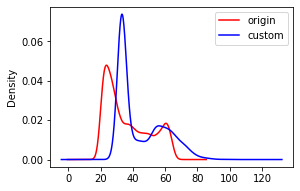


height_cm


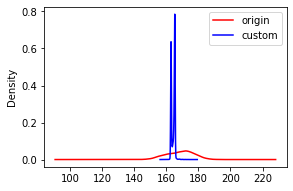


weight_kg


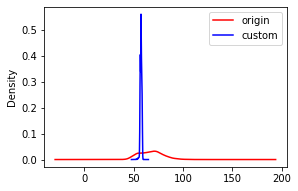


body fat_%


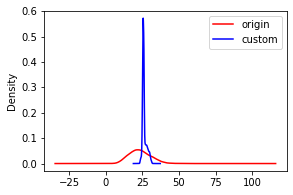


diastolic


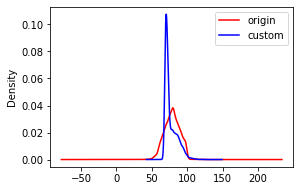


systolic


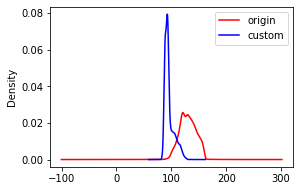


gripForce


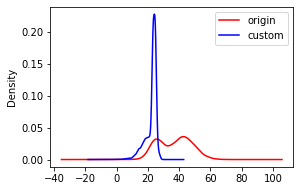


sit and bend forward_cm


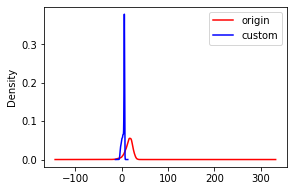


sit-ups counts


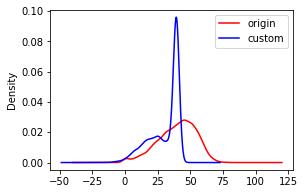


broad jump_cm


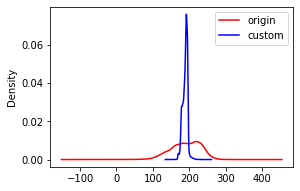

In [35]:
# For each feature, create a histogram for the real and synthetic data
#dataframes = [data, generated_data]#[data, s_Data, sdv_Data]
dataframes = [data, synthetic_data]
#dataframes = list(dfs.keys())[1]
colors = ['r', 'b', 'g']
for feature in columns:
    print(feature)
    plt.figure(figsize=(20, 10))
    for x in range(3):
        for y in range(4):
            #name = dataframes[y+4*x]
            #name = dataframes
            plt.subplot(3, 4, 1+y+4*x)
            #plt.hist(dfs[name][feature], bins=10, alpha=0.5, label=name, density = True)
            #data[feature].plot.kde()
            for x in range(len(dataframes)):
                dataframes[x][feature].plot.kde(color = colors[x])
            #plt.title(f"{name}")
            plt.legend(['origin', 'custom', 'sdv'])
            break
        break
    plt.show()
    print()

age - height_cm


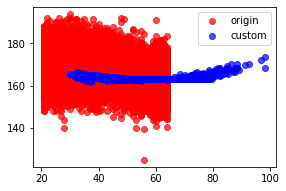


age - weight_kg


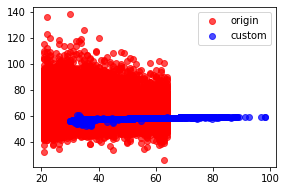


age - body fat_%


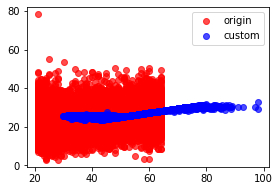


age - diastolic


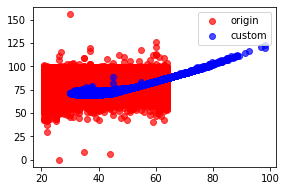


age - systolic


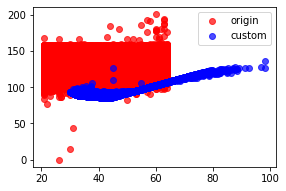


age - gripForce


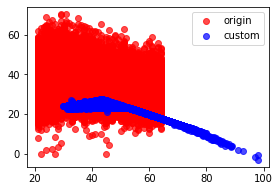


age - sit and bend forward_cm


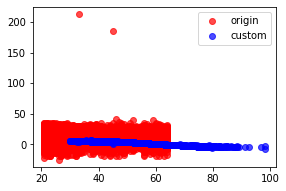


age - sit-ups counts


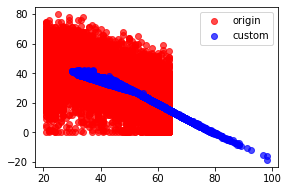


age - broad jump_cm


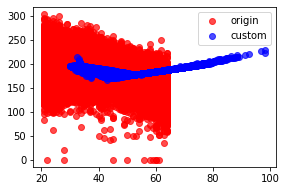


height_cm - weight_kg


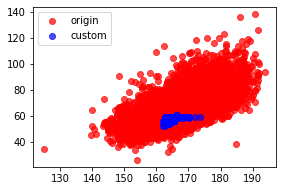


height_cm - body fat_%


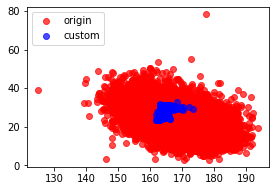


height_cm - diastolic


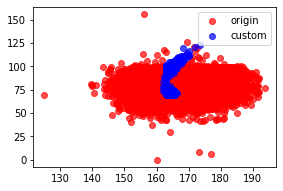


height_cm - systolic


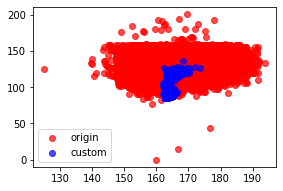


height_cm - gripForce


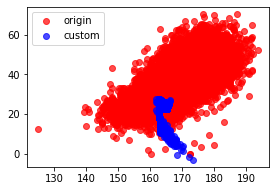


height_cm - sit and bend forward_cm


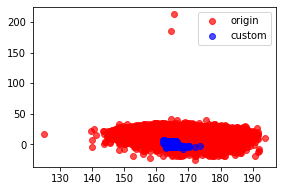


height_cm - sit-ups counts


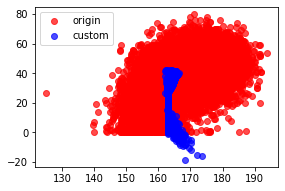


height_cm - broad jump_cm


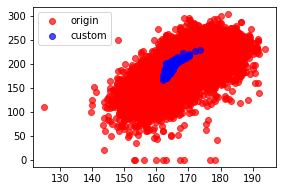


weight_kg - body fat_%


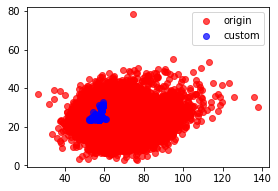


weight_kg - diastolic


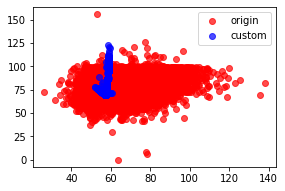


weight_kg - systolic


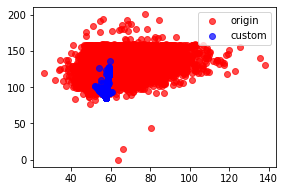


weight_kg - gripForce


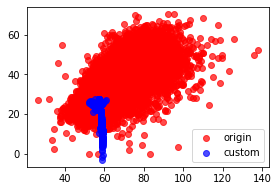


weight_kg - sit and bend forward_cm


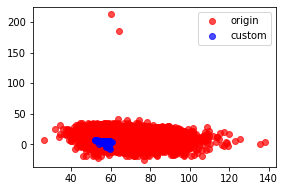


weight_kg - sit-ups counts


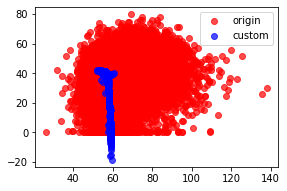


weight_kg - broad jump_cm


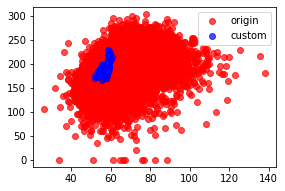


body fat_% - diastolic


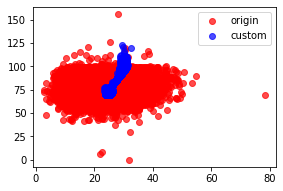


body fat_% - systolic


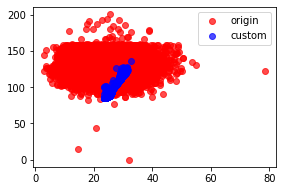


body fat_% - gripForce


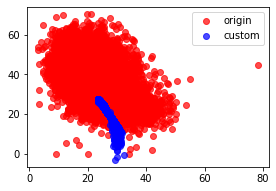


body fat_% - sit and bend forward_cm


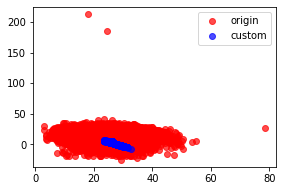


body fat_% - sit-ups counts


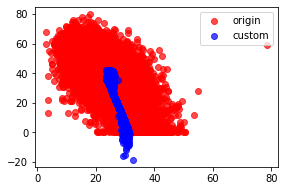


body fat_% - broad jump_cm


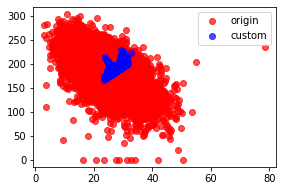


diastolic - systolic


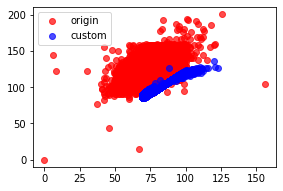


diastolic - gripForce


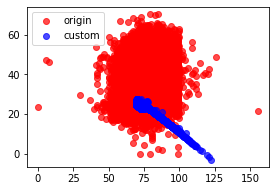


diastolic - sit and bend forward_cm


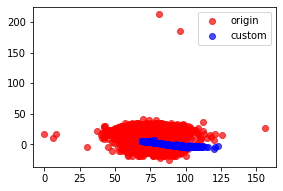


diastolic - sit-ups counts


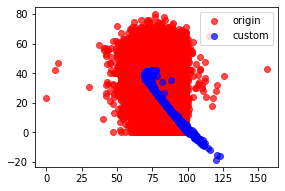


diastolic - broad jump_cm


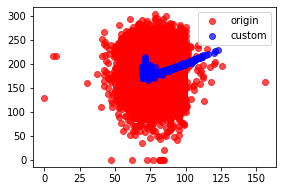


systolic - gripForce


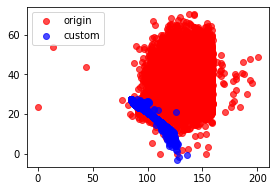


systolic - sit and bend forward_cm


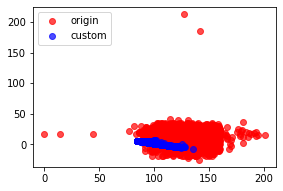


systolic - sit-ups counts


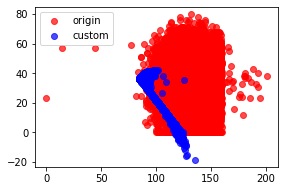


systolic - broad jump_cm


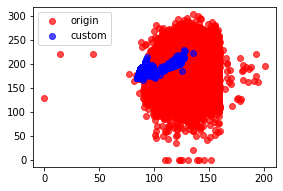


gripForce - sit and bend forward_cm


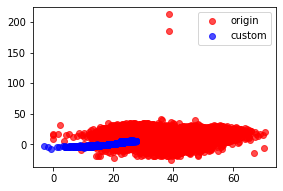


gripForce - sit-ups counts


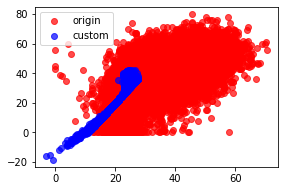


gripForce - broad jump_cm


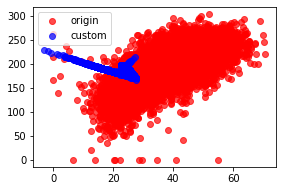


sit and bend forward_cm - sit-ups counts


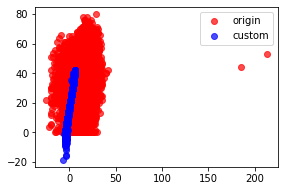


sit and bend forward_cm - broad jump_cm


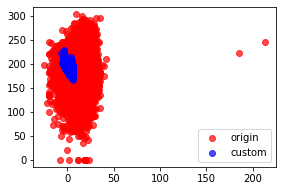


sit-ups counts - broad jump_cm


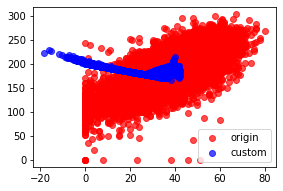

In [36]:
# For each feature, create a histogram for the real and synthetic data
#dataframes = list(dfs.keys())[1]
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        plt.figure(figsize=(20, 10))
        for x in range(3):
            for y in range(4):
                print(columns[i], '-', columns[j])
                #name = dataframes[y+4*x]
                #name = dataframes
                plt.subplot(3, 4, 1+y+4*x)
                #plt.scatter(data[columns[i]], data[columns[j]], alpha=0.7, color = 'r')
                #plt.scatter(dfs[name][columns[i]], dfs[name][columns[j]], alpha=0.1, color = 'g')
                for x in range(len(dataframes)):
                    plt.scatter(dataframes[x][columns[i]], dataframes[x][columns[j]], alpha=0.7, color = colors[x])
                #plt.title(f"{name}")
                #plt.legend()
                plt.legend(['origin', 'custom'])#, 'sdv'])
                break
            break
        plt.show()
        print()